# CS229 Project (Spring 2022)
### By Aivar Abrashuly and Janet Zhong

In this project we are extending Ben Bartlett's work on programmable quantum gate arrays. 


# In this section, we will import/ install all the stuff.
Have to make sure to use tensorflow 1.14. Also install squanch from github instead of pip install, otherwise there is a use_densitymatrix=False error

In [1]:
#!pip uninstall squanch

In [3]:
pip install git+https://github.com/att-innovate/squanch.git


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/att-innovate/squanch.git to /tmp/pip-req-build-5g0094zj
  Running command git clone -q https://github.com/att-innovate/squanch.git /tmp/pip-req-build-5g0094zj


In [4]:
import inspect
import squanch
lines = inspect.getsource(squanch.QStream)
print(lines)

class QStream:
    '''
    Efficiently represents many separable quantum subsystems in a contiguous block of shared memory.
    ``QSystem``s and ``Qubit``s can be instantiated from the ``state`` of this class.
    '''

    def __init__(self, system_size, num_systems, array = None, agent = None, use_density_matrix = True):
        '''
        Instantiate the quantum datastream object

        :param int system_size: number of entangled qubits in each quantum system; each system has dims 2^system_size
        :param int num_systems: number of small quantum systems in the data stream
        :param np.array array: pre-allocated array in memory for purposes of sharing QStreams in multiprocessing
        :param Agent agent: optional reference to the Agent owning the qstream; useful for progress monitoring across
                            separate processes
        '''
        self.system_size = system_size  # number of qubits per system
        self.num_systems = num_systems  # number of 

In [5]:
!pip install qutip
!pip install tensorflow==1.14
#!pip install squanch
!pip install keras==2.3.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [7]:
%cd /content/drive/MyDrive/qpga

/content/drive/MyDrive/qpga


In [8]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap

import qutip
import h5py

from qpga import *
from qpga.model import QPGA
from qpga.circuits import QFT, QFT_layer_count, cluster_state_generator
from qpga.training import *
from qpga.fidelity_search import *
from qpga.linalg import *
from qpga.plotting import *
from qpga.state_preparation import *
from qpga.callbacks import *
from qpga.utils import *

from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras import backend as K
K.set_floatx('float64')

%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

%config InlineBackend.figure_format = 'retina'
np.set_printoptions(precision=3, linewidth=300)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [10]:
# keras version
from tensorflow import keras
keras.__version__

'2.2.4-tf'

In [9]:
%tensorflow_version
import tensorflow
tensorflow.__version__

Currently selected TF version: 2.x
Available versions:
* 1.x
* 2.x


'1.14.0'

# Approximating the algorithm required to get specific quantum states

In this section we can use learning to provide approximate (but more compact) algorithms to prepare arbitrary quantum states.


# Initial experiments for different quantum states (NOON and Bell)
This was some older results for the project milestone


### NOON states
Ben has some predefined code for noon_state in state_preparation.py.

In [ ]:
in_data = np_to_k_complex(np.array([noon_state(N)] * num_states))
in_data

array([[[0.707, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.707],
        [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]],

       [[0.707, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.707],
        [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]],

       [[0.707, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.707],
        [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]],

       [[0.707, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.707],
        [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]],

       [[0.707, 

In [ ]:
# num_states is the number of trial states that it will do gradient descent on, then it uses the average fidelity
num_states = 10
# N is the number of qubits
N=4
depths = list(range(N, 999))
in_data = np_to_k_complex(np.array([zero_state(N)] * num_states))
out_data = np_to_k_complex(np.array([noon_state(N)] * num_states))

fidelities = fidelity_depth_search(depths, path=".",
                                    in_data = in_data,
                                    out_data = out_data,
                                    max_epochs = 100,
                                    return_on_first_convergence = True)

So the training completed but would be good to plot the predicted output for each depth. it keeps adding a unit layer to the depth of the quantum circuit till it reaches the desired fidelity. Think of a nicer plot later...

In [ ]:
# gives a dictionary of the circuit depth and the final fidelity of the apprximate compact algorithm for the predicted output state
fidelities

{4: 0.9992062949499436}

## Bell state

So we should try add something to Ben's code to show that we can do some other states too. Here we find the approximate quantum algorithm to generate Bell states.


In [ ]:
# We want Bell states of the form:
# bellstate_00= np.array([0.70710678+0.j, 0.        +0.j, 0.        +0.j, 0.70710678+0.j])
# bellstate_01= np.array([0.        +0.j, 0.70710678+0.j       ,0.70710678+0.j, 0.        +0.j])
# bellstate_10= np.array([0.70710678+0.j, 0.        +0.j, 0.        +0.j, -0.70710678+0.j])
# bellstate_11= np.array([0.        +0.j, 0.70710678+0.j       ,-0.70710678+0.j, 0.        +0.j])


In [ ]:
bellstate_00= np.array([0.70710678+0.j, 0.        +0.j, 0.        +0.j, 0.70710678+0.j])
bellstate_01= np.array([0.        +0.j, 0.70710678+0.j       ,0.70710678+0.j, 0.        +0.j])
bellstate_10= np.array([0.70710678+0.j, 0.        +0.j, 0.        +0.j, -0.70710678+0.j])
bellstate_11= np.array([0.        +0.j, 0.70710678+0.j       ,-0.70710678+0.j, 0.        +0.j])


num_states = 10
N=2
depths = list(range(N, 999))
in_data = np_to_k_complex(np.array([zero_state(N)] * num_states))
out_data = np_to_k_complex(np.array([bellstate_00] * num_states))

fidelities = fidelity_depth_search(depths, path=".",
                                    in_data = in_data,
                                    out_data = out_data,
                                    max_epochs = 100,
                                    return_on_first_convergence = True)




Training circuit of depth 2 =============================================================


=> Attempt 1/2...
Instantiating model with 2 qubits and depth of 2...
Building model...
Done building.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 4)                 0         
_________________________________________________________________
single_qubit_operation_layer (None, 4)                 8         
_________________________________________________________________
c_phase_layer (CPhaseLayer)  (None, 4)                 0         
_________________________________________________________________
single_qubit_operation_layer (None, 4)                 8         
_________________________________________________________________
c_phase_layer_1 (CPhaseLayer (None, 4)                 0         
________________________________________________________

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Done compiling.
Fitting model...
Train on 9 samples, validate on 1 samples
Epoch 1/100
9/9 - 1s - loss: 0.9540 - antifidelity: 0.9540 - val_loss: 0.9406 - val_antifidelity: 0.9406
Epoch 2/100
9/9 - 0s - loss: 0.9406 - antifidelity: 0.9406 - val_loss: 0.9251 - val_antifidelity: 0.9251
Epoch 3/100
9/9 - 0s - loss: 0.9251 - antifidelity: 0.9251 - val_loss: 0.9075 - val_antifidelity: 0.9075
Epoch 4/100
9/9 - 0s - loss: 0.9075 - antifidelity: 0.9075 - val_loss: 0.8880 - val_antifidelity: 0.8880
Epoch 5/100
9/9 - 0s - loss: 0.8880 - antifidelity: 0.8880 - val_loss: 0.8667 - val_antifidelity: 0.8667
Epoch 6/100
9/9 - 0s - loss: 0.8667 - antifidelity: 0.8667 - val_loss: 0.8435 - val_antifidelity: 0.8435
Epoch 7/100
9/9 - 0s - loss: 0.8435 - antifidelity: 0.8435 - val_loss: 0.8186 - val_antifidelity: 0.8186
Epoch 8/100
9/9 - 0s - loss: 0.8186 - antifidelity: 0.8186 - val_loss: 0.7919 - val_antifidelity: 0.7919
Epoch 9/100
9/9 - 0s - loss: 0.7919 - antifidelity: 0.7919 - val_loss: 0.7636 - val_a

In [ ]:
#bellstate 00
fidelities

{2: 0.9484034070686336, 3: 0.9996244173590222}

# Compare state preparation vs Grover's algorithm

This is for the final project. The plot for the figures is adapted from Ben's code here: https://github.com/fancompute/qpga/blob/master/qpga_figures.ipynb.


In [11]:
# num_states is the number of trial states that it will do gradient descent on, then it uses the average fidelity
num_states = 10
# N is the number of qubits
N=4
depths = list(range(N, 999))
in_data = np_to_k_complex(np.array([zero_state(N)] * num_states))
out_1111 = np.array(([[[0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0, 0., 0],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0, 0., 1]]]*num_states))
out_data = out_1111

fidelities = fidelity_depth_search(depths, path=".",
                                    in_data = in_data,
                                    out_data = out_data,
                                    max_epochs = 100,
                                    return_on_first_convergence = True)




Training circuit of depth 4 =============================================================


=> Attempt 1/2...
Instantiating model with 4 qubits and depth of 4...


Building model...
Done building.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 16)                0         
_________________________________________________________________
single_qubit_operation_layer (None, 16)                16        
_________________________________________________________________
c_phase_layer (CPhaseLayer)  (None, 16)                0         
_________________________________________________________________
single_qubit_operation_layer (None, 16)                16        
_________________________________________________________________
c_phase_layer_1 (CPhaseLayer (None, 16)                0         
_________________________________________________________________
single_qubit_operation_layer (None, 16)                16        
_________________________________________________________________
c_phase_layer_2 (CPhase

Building model...
Done building.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 16)                0         
_________________________________________________________________
single_qubit_operation_layer (None, 16)                16        
_________________________________________________________________
c_phase_layer (CPhaseLayer)  (None, 16)                0         
_________________________________________________________________
single_qubit_operation_layer (None, 16)                16        
_________________________________________________________________
c_phase_layer_1 (CPhaseLayer (None, 16)                0         
_________________________________________________________________
single_qubit_operation_layer (None, 16)                16        
_________________________________________________________________
c_phase_layer_2 (CPhase

In [12]:
fidelities

{4: 0.9990587730881552}

In [10]:
# num_states is the number of trial states that it will do gradient descent on, then it uses the average fidelity
num_states = 10
# N is the number of qubits
N=7
depths = list(range(N, 999))
in_data = np_to_k_complex(np.array([zero_state(N)] * num_states))
out_11_oracle =np_to_k_complex(np.array([zero_state(N)][::-1] * num_states)) 
out_data = out_11_oracle


fidelities = fidelity_depth_search(depths, path=".",
                                    in_data = in_data,
                                    out_data = out_data,
                                    max_epochs = 100,
                                    return_on_first_convergence = True)




Training circuit of depth 7 =============================================================


=> Attempt 1/2...
Instantiating model with 7 qubits and depth of 7...


Building model...
Done building.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer (CPhaseLayer)  (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_1 (CPhaseLayer (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_2 (CPhase

Building model...
Done building.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer (CPhaseLayer)  (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_1 (CPhaseLayer (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_2 (CPhase

Building model...
Done building.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer (CPhaseLayer)  (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_1 (CPhaseLayer (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_2 (CPhase

Building model...
Done building.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer (CPhaseLayer)  (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_1 (CPhaseLayer (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_2 (CPhase

Building model...
Done building.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer (CPhaseLayer)  (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_1 (CPhaseLayer (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_2 (CPhase

Building model...
Done building.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer (CPhaseLayer)  (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_1 (CPhaseLayer (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_2 (CPhase

Building model...
Done building.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer (CPhaseLayer)  (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_1 (CPhaseLayer (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_2 (CPhase

Building model...
Done building.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer (CPhaseLayer)  (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_1 (CPhaseLayer (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_2 (CPhase

Building model...
Done building.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer (CPhaseLayer)  (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_1 (CPhaseLayer (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_2 (CPhase

Building model...
Done building.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer (CPhaseLayer)  (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_1 (CPhaseLayer (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_2 (CPhase

Building model...
Done building.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer (CPhaseLayer)  (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_1 (CPhaseLayer (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_2 (CPhase

Building model...
Done building.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer (CPhaseLayer)  (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_1 (CPhaseLayer (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_2 (CPhase

Building model...
Done building.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer (CPhaseLayer)  (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_1 (CPhaseLayer (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_2 (CPhase

Building model...
Done building.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer (CPhaseLayer)  (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_1 (CPhaseLayer (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_2 (CPhase

Building model...
Done building.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer (CPhaseLayer)  (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_1 (CPhaseLayer (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_2 (CPhase

Building model...
Done building.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer (CPhaseLayer)  (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_1 (CPhaseLayer (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_2 (CPhase

Building model...
Done building.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer (CPhaseLayer)  (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_1 (CPhaseLayer (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_2 (CPhase

Building model...
Done building.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer (CPhaseLayer)  (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_1 (CPhaseLayer (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_2 (CPhase

Building model...
Done building.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer (CPhaseLayer)  (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_1 (CPhaseLayer (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_2 (CPhase

Building model...
Done building.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer (CPhaseLayer)  (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_1 (CPhaseLayer (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_2 (CPhase

Building model...
Done building.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer (CPhaseLayer)  (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_1 (CPhaseLayer (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_2 (CPhase

Building model...
Done building.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer (CPhaseLayer)  (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_1 (CPhaseLayer (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_2 (CPhase

Building model...
Done building.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer (CPhaseLayer)  (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_1 (CPhaseLayer (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_2 (CPhase

Building model...
Done building.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer (CPhaseLayer)  (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_1 (CPhaseLayer (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_2 (CPhase

Building model...
Done building.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer (CPhaseLayer)  (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_1 (CPhaseLayer (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_2 (CPhase

Building model...
Done building.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer (CPhaseLayer)  (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_1 (CPhaseLayer (None, 128)               0         
_________________________________________________________________
single_qubit_operation_layer (None, 128)               28        
_________________________________________________________________
c_phase_layer_2 (CPhase

KeyboardInterrupt: ignored

### Nicer figure

I made some small changes, in callbacks.py, I changed the following

In [62]:
    # def on_train_begin(self, logs = None):
    #     # Compute initial fidelity
    #     if self.input_state is not None and self.target_state is not None:
    #         antifidelity = self.model.evaluate(self.input_state, self.target_state)
    #         #self.fidelities.append(1 - antifidelity) #original
    #         self.fidelities.append(1 - np.mean(antifidelity))
    #         print('antifidelity')
    #         print(np.mean(antifidelity))
    #         print('fidelity')
    #         print(1-np.mean(antifidelity))
    #         #self.fidelities.append(np.ones(len(antifidelity)) - antifidelity) #list
    #         #output_state = self.model.predict(self.in_data) #original
    #         output_state = self.model.predict(self.input_state) 
    #         self.output_states.append(output_state)

Training. We are going to compare the depth required to go from an initial state of zero state to a desired output search state of |w>=|0000>. In https://medium.com/quantum-untangled/grovers-algorithm-mathematics-circuits-and-code-quantum-algorithms-untangled-c4aa47d506e5, they calculate it exactly. https://quantumcomputinguk.org/tutorials/grovers-algorithm-with-code has more examples. We will see how many depths it takes the QPGA to do it in.

In [22]:
#Prints the basis
def get_basis_state(n, num_qubits):
    '''Gets the nth computational basis vector in the 2^num_qubits dimensional space'''
    assert n < 2 ** num_qubits
    return np.array(list(map(int, format(n, 'b').zfill(num_qubits))), dtype=np.complex128)
num_qubits = 4
for i in range(2**num_qubits):
  print(get_basis_state(i,4).real)

[0. 0. 0. 0.]
[0. 0. 0. 1.]
[0. 0. 1. 0.]
[0. 0. 1. 1.]
[0. 1. 0. 0.]
[0. 1. 0. 1.]
[0. 1. 1. 0.]
[0. 1. 1. 1.]
[1. 0. 0. 0.]
[1. 0. 0. 1.]
[1. 0. 1. 0.]
[1. 0. 1. 1.]
[1. 1. 0. 0.]
[1. 1. 0. 1.]
[1. 1. 1. 0.]
[1. 1. 1. 1.]


In [8]:
N = 4
num_samples = 1

in_data = np_to_k_complex(np.array([zero_state(N)] * num_samples))
out_0000_oracle = np.array([[[1, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0, 0., 0],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0, 0., 0]]])
out_data = out_0000_oracle

model = QPGA(N, 20).as_sequential()
model.compile(optimizer=Adam(lr=0.002), 
              loss=antifidelity, 
              metrics=[antifidelity])

callback = StatePreparationHistoryCallback(num_qubits=N, input_state = in_data[0:1], target_state = out_data[0:1])
reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(monitor = 'loss', 
                                                       factor = 0.25,
                                                       patience = 2,
                                                       verbose=1,
                                                       min_lr=1e-6)

history = model.fit(in_data, out_data, epochs=201, 
                    callbacks=[callback, reduce_lr_callback], verbose = 2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


1/1 [==============================] - 2s 2s/sample - loss: 0.8464 - antifidelity: 0.8464
antifidelity
0.8463631839818073
fidelity
0.15363681601819268
Epoch 1/201
1/1 [==============================] - 0s 10ms/sample - loss: 0.8194 - antifidelity: 0.8194
1/1 - 8s - loss: 0.8464 - antifidelity: 0.8464
Epoch 2/201
1/1 [==============================] - 0s 11ms/sample - loss: 0.7911 - antifidelity: 0.7911
1/1 - 0s - loss: 0.8194 - antifidelity: 0.8194
Epoch 3/201
1/1 [==============================] - 0s 10ms/sample - loss: 0.7618 - antifidelity: 0.7618
1/1 - 0s - loss: 0.7911 - antifidelity: 0.7911
Epoch 4/201
1/1 [==============================] - 0s 10ms/sample - loss: 0.7317 - antifidelity: 0.7317
1/1 - 0s - loss: 0.7618 - antifidelity: 0.7618
Epoch 5/201
1/1 [==============================] - 0s 10ms/sample - loss: 0.7013 - antifidelity: 0.7013
1/1 - 0s - loss: 0.7317 - antifidelity: 0.7317
Epoch 6/201
1/1 [==============================] - 0s 9ms/sample - loss: 0.6709 - antifidelity

In [9]:
from matplotlib import cm
viridis = cm.get_cmap('viridis', 12)
print(viridis)


In [14]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  cm-super-minimal fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre ghostscript gsfonts javascript-common
  libcupsfilters1 libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libpotrace0 libptexenc1 libruby2.5 libsynctex1
  libtexlua52 libtexluajit2 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data
  preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto ghostscript-x apach

[0.154 0.154 0.181 0.209 0.238 0.268 0.299 0.329 0.359 0.389 0.419 0.448 0.476 0.503 0.529 0.553 0.577 0.599 0.619 0.639 0.657 0.675 0.692 0.708 0.723 0.738 0.753 0.767 0.78  0.793 0.806 0.818 0.83  0.841 0.853 0.863 0.874 0.884 0.894 0.904 0.913 0.921 0.93  0.937 0.945 0.951 0.957 0.963 0.968
 0.972 0.976 0.979 0.982 0.984 0.986 0.987 0.989 0.99  0.991 0.992 0.993 0.994 0.994 0.995 0.995 0.996 0.996 0.997 0.997 0.997 0.997 0.998 0.998 0.998 0.998 0.998 0.998 0.998 0.999 0.999 0.999 0.999 0.999 0.999 0.999 0.999 0.999 0.999 0.999 1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.   ]


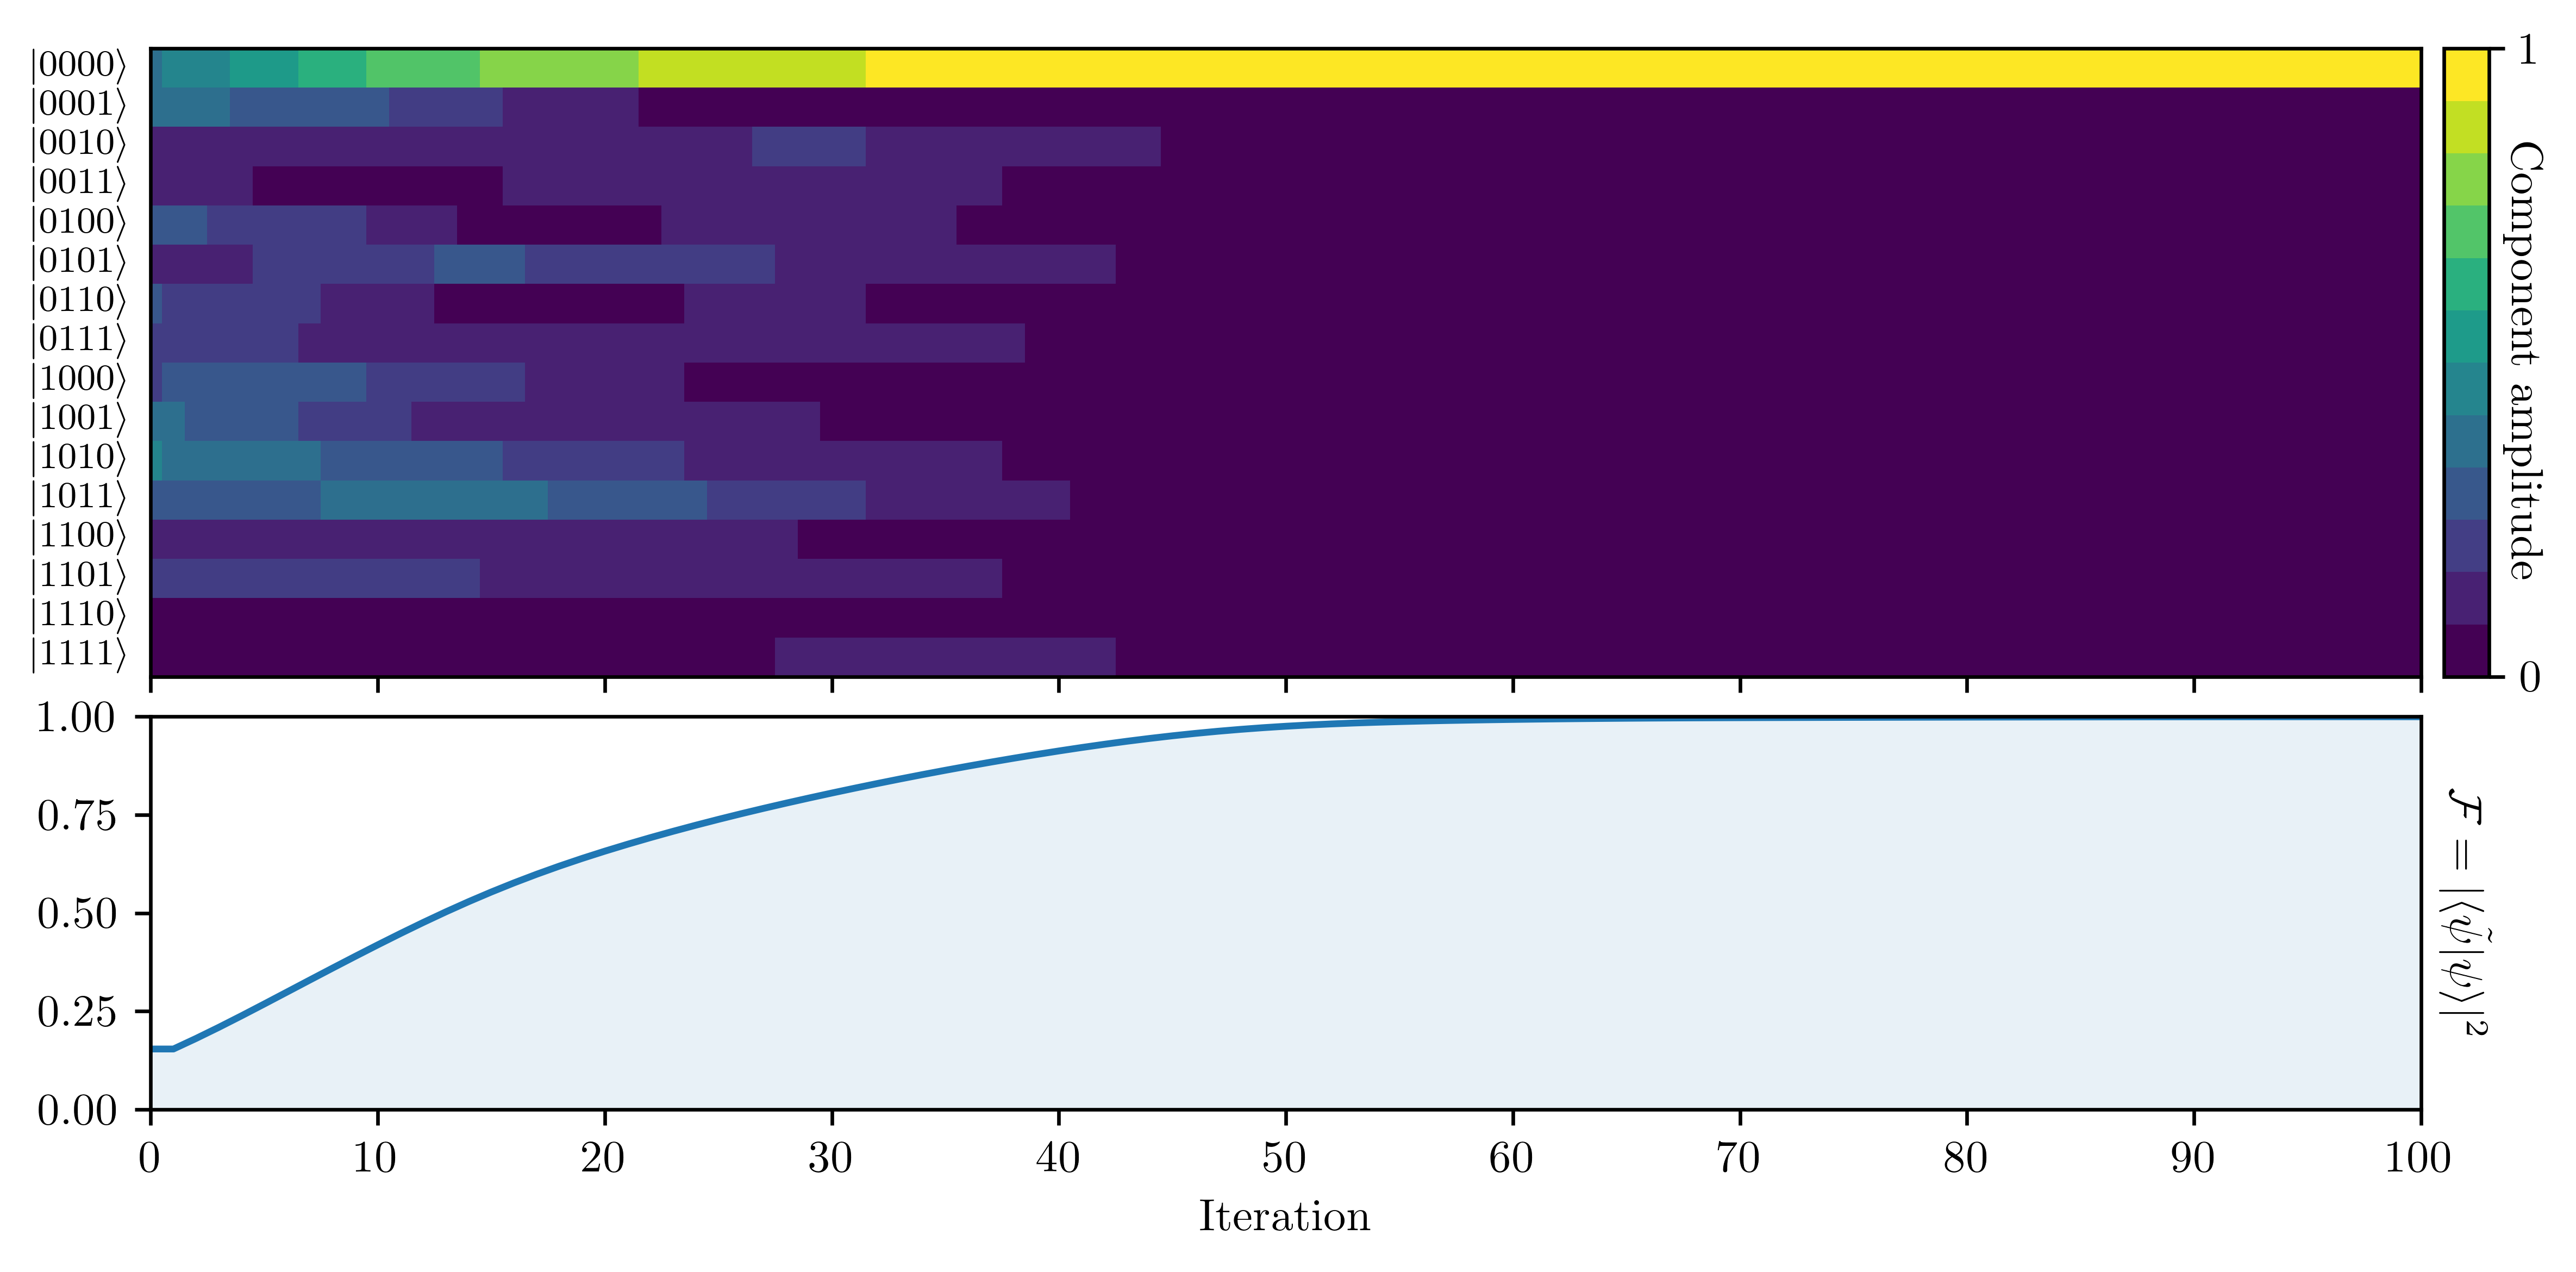

In [19]:
def plot_state_prep_training(filepath, max_epoch=None, savefig=False):
    
    f = h5py.File(filepath, 'r')
    
    input_state = np.array(f['input_state'])
    target_state = np.array(f['target_state'])
    output_states = np.array(f['output_states'])
    fidelities = np.array(f['fidelities'])
    
    output_states = k_to_np_complex(np.array(output_states)[:,0])
    
    if max_epoch is not None:
        output_states = output_states[:max_epoch]
        fidelities = fidelities[:max_epoch]
    
    kets = computational_basis_labels(N, include_bras=False)
    
    # Make figure and axis layout
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(8,4), gridspec_kw={'height_ratios': [2,1.25]}, sharex=True)

    # Plot state over training
    cmap=viridis
    ax1.imshow(np.abs(np.transpose(output_states)), aspect='auto', cmap=cmap)
    ax1.set_xticks([])
    ax1.yaxis.set_major_locator(plt.IndexLocator(base=1, offset=0.35))
    ax1.yaxis.set_ticks_position('none')
    ax1.set_yticklabels(kets)
    ax1.tick_params(axis = 'y', labelsize = 8, pad = 0)
    
    # Add a colorbar
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size = '2%', pad = '1%')
    cbar = mpl.colorbar.ColorbarBase(cax, cmap = cmap,
                                      norm = mpl.colors.Normalize(0, 1),
                                      ticks = [0, 1])
    cax.get_yaxis().labelpad=0
    cax.set_ylabel("Component amplitude",rotation=270)
    cax.set_yticklabels(["$0$", "$1$"])
#     cax.text(0.5, 0.0, '$0$', transform = cax.transAxes, va = 'top', ha = 'center')
#     cax.text(0.5, 1.0, '$1/\sqrt{2}$', transform = cax.transAxes, va = 'bottom', ha = 'center')

    # Plot antifidelity
    loss_plot(fidelities, x_units='iterations', fig=fig, ax=ax2, ylabel="$\mathcal{F} = | \langle \\tilde{\psi} | \psi \\rangle |^2$", ylabel_pos='right')
    # Add a dummy axis to keep alignment
    divider = make_axes_locatable(ax2)
    dummyax = divider.append_axes('right', size = '2%', pad = '1%')
    dummyax.set_visible(False)
    print(fidelities)
    fig.tight_layout(h_pad=0)
    
    # Save frame
    if savefig:
        plt.savefig("assets/oracle0000_prep.pdf", dpi=300, bbox_inches='tight', pad_inches=0.025)
    else:
        plt.show()

# oracle 0000
plot_state_prep_training("state_history_4_qubits_2022.06.07.01.24.05.h5", max_epoch=101, savefig=True)

# Approximate quantum algorithms for quantum operators
Now instead of states we shall do algorithms. Ben has already done QFT, so we shall replicate that here, he also did a cluster state generator. We shall try to implement Grover's algorithm 

Below is the file for circuits.py which implements the exact QFT using squanch

## QFT

In [11]:

def prepare_training_data(squanch_circuit, num_qubits, num_states, convert_to_k_complex = True):
    # Generate random state vectors
    in_states = np.array([get_random_state_vector(num_qubits) for _ in range(num_states)])
    in_states[0] = np.array([1] + [0] * (2 ** num_qubits - 1),
                            dtype = np.complex128)  # first state should be zero qubit

    # Prepare a squanch qstream to operate on
    qstream = QStream.from_array(np.copy(in_states), use_density_matrix = False)
    #qstream = QStream.from_array(np.copy(in_states))
    #qstream = QStream.from_array(np.array([np.outer(x, x.conj()) for x in np.copy(in_states)]))

    # Apply the circuit to the input states
    for qsys in tqdm(qstream):
        squanch_circuit(list(qsys.qubits))

    out_states = np.copy(qstream.state)

    if convert_to_k_complex:
        in_states = np_to_k_complex(in_states)
        out_states = np_to_k_complex(out_states)

    return in_states, out_states

In [33]:
N = 5
in_data, out_data = prepare_training_data(QFT, N, 1000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
in_data.shape


(1000, 2, 16)

In [13]:
out_data.shape

(1000, 2, 16)

In [34]:
model = QPGA(N, 60).as_sequential()
model.build(in_data.shape)


model.compile(optimizer = Adam(lr = 0.0001),
              loss = antifidelity,
              metrics = [antifidelity])

operator_vis = OperatorHistoryCallback(num_qubits=N, in_data=in_data, out_data=out_data)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                              factor = 0.5,
                                              cooldown = 4,
                                              patience = 2,
                                              verbose = 1,
                                              min_lr = 1e-6)
callbacks = [operator_vis, reduce_lr]

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 32)                0         
_________________________________________________________________
single_qubit_operation_layer (None, 32)                20        
_________________________________________________________________
c_phase_layer_60 (CPhaseLaye (None, 32)                0         
_________________________________________________________________
single_qubit_operation_layer (None, 32)                20        
_________________________________________________________________
c_phase_layer_61 (CPhaseLaye (None, 32)                0         
_________________________________________________________________
single_qubit_operation_layer (None, 32)                20        
_________________________________________________________________
c_phase_layer_62 (CPhaseLaye (None, 32)               

In [35]:
history = model.fit(in_data, out_data,
                    epochs = 200,
                    validation_split = 0.1,
                    callbacks = callbacks,
                    verbose=1)

Train on 900 samples, validate on 100 samples
1000/1000 [==============================] - 9s 9ms/sample - loss: 0.9678 - antifidelity: 0.9678
Initial fidelity: [0.9677832366824151, 0.9677832358641022]
Epoch 1/200
900/900 [==============================] - 35s 39ms/sample - loss: 0.9673 - antifidelity: 0.9673 - val_loss: 0.9721 - val_antifidelity: 0.9721
Epoch 2/200
900/900 [==============================] - 7s 8ms/sample - loss: 0.9667 - antifidelity: 0.9667 - val_loss: 0.9718 - val_antifidelity: 0.9718
Epoch 3/200
900/900 [==============================] - 5s 6ms/sample - loss: 0.9663 - antifidelity: 0.9663 - val_loss: 0.9716 - val_antifidelity: 0.9716
Epoch 4/200
900/900 [==============================] - 5s 6ms/sample - loss: 0.9658 - antifidelity: 0.9658 - val_loss: 0.9714 - val_antifidelity: 0.9714
Epoch 5/200
900/900 [==============================] - 5s 6ms/sample - loss: 0.9654 - antifidelity: 0.9654 - val_loss: 0.9711 - val_antifidelity: 0.9711
Epoch 6/200
900/900 [==========

In [36]:
def plot_frames(filepath, num_qubits=N, num_epochs=None):
    
    f = h5py.File(filepath, 'r')
    
    fidelities_train = np.array(f['fidelities_train'])
    fidelities_val = np.array(f['fidelities_val'])
    operators = np.array(f['operators'])
    
    num_epochs = len(fidelities_train) if num_epochs is None else num_epochs

    operator_targ = extract_operator_from_circuit(QFT, num_qubits)
    kets, bras = computational_basis_labels(num_qubits, include_bras=True)
    
    for i in pbar(range(num_epochs)):
        
        global_phase = np.mean(np.angle(operators[i]/operator_targ))
        operator = operators[i] / np.exp(1j * global_phase)

        # Make figure and axis layout
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')
        fig = plt.figure(figsize=(12,9), tight_layout=True)
        gs = mpl.gridspec.GridSpec(2, 2, height_ratios = [2, 1])

        ax1 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[0, 1])

        # Plot operator visualizations
        hinton(operator, xlabels=kets, ylabels=bras, fig=fig, ax=ax1, title="$\\tilde{U}$")
        hinton(operator_targ, xlabels=kets, ylabels=bras, fig=fig, ax=ax2, title="$\hat{U}$")

        # Plot antifidelity
        fidel_val = fidelities_val[0:i]
        fidel_train = fidelities_train[0:i]
        ax_bot = fig.add_subplot(gs[1, :])
        loss_plot(fidel_val, fidel_train, x_units='iterations', x_max = num_epochs, fig=fig, ax=ax_bot)

        # Save frame
        title = str(i).zfill(4)
        plt.savefig("assets/frames/qft_{}.png".format(title), dpi=300, bbox_inches='tight', pad_inches=0)
        plt.close()

In [37]:
!ls

assets
CS229milestone_qpga_tests.ipynb
fidelity_search.py
get-pip.py
LICENSE
Miniconda3-4.5.4-Linux-x86_64.sh
model.h5
operator_history_4_qubits_2022.06.06.19.40.16.h5
operator_history_5_qubits_2022.06.06.21.07.08.h5
QFT_2_qubits_fidelities.pickle
QFT_3_qubits_fidelities.pickle
QFT_4_qubits_fidelities.pickle
QFT_5_qubits_fidelities.pickle
qpga
QPGA_extensions.ipynb
qpga_figures.ipynb
README.md
scripts
tensorboard


In [29]:
!pip install latex
!pip install dvipng
!pip install Ghostscript

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement dvipng (from versions: none)
ERROR: No matching distribution found for dvipng
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
plt.rc('text', usetex=False)
plot_frames('operator_history_4_qubits_2022.06.06.19.40.16.h5', num_qubits=4, num_epochs=200)

  0%|          | 0/200 [00:01<?, ?it/s]


RuntimeError: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f659a634830> (for post_execute):


RuntimeError: ignored

RuntimeError: ignored

<Figure size 3600x2700 with 5 Axes>

In [31]:
# Define the nic_Edge cyclic colormap 

nic_edge_colors = np.array([
    [0.191208, 0.191208, 0.191208],
    [0.239484, 0.00545035, 0.614821],
    [0.220593, 0.0617459, 0.863547],
    [0.17509, 0.278988, 0.97794],
    [0.143526, 0.576069, 0.998553],
    [0.166456, 0.871883, 0.96594],
    [0.376202, 0.993555, 0.981833],
    [0.681996, 0.991297, 0.999239],
    [0.954172, 0.952734, 0.94374],
    [0.999735, 0.99301, 0.662896],
    [0.979399, 0.991466, 0.357973],
    [0.968771, 0.854967, 0.162659],
    [0.999245, 0.556697, 0.144323],
    [0.973959, 0.26223, 0.177946],
    [0.852358, 0.0526707, 0.222974],
    [0.593889, 0.00912724, 0.238855],
    [0.191208, 0.191208, 0.191208]
])
nic_edge = ListedColormap(nic_edge_colors)

In [42]:
import matplotlib.pyplot as plt

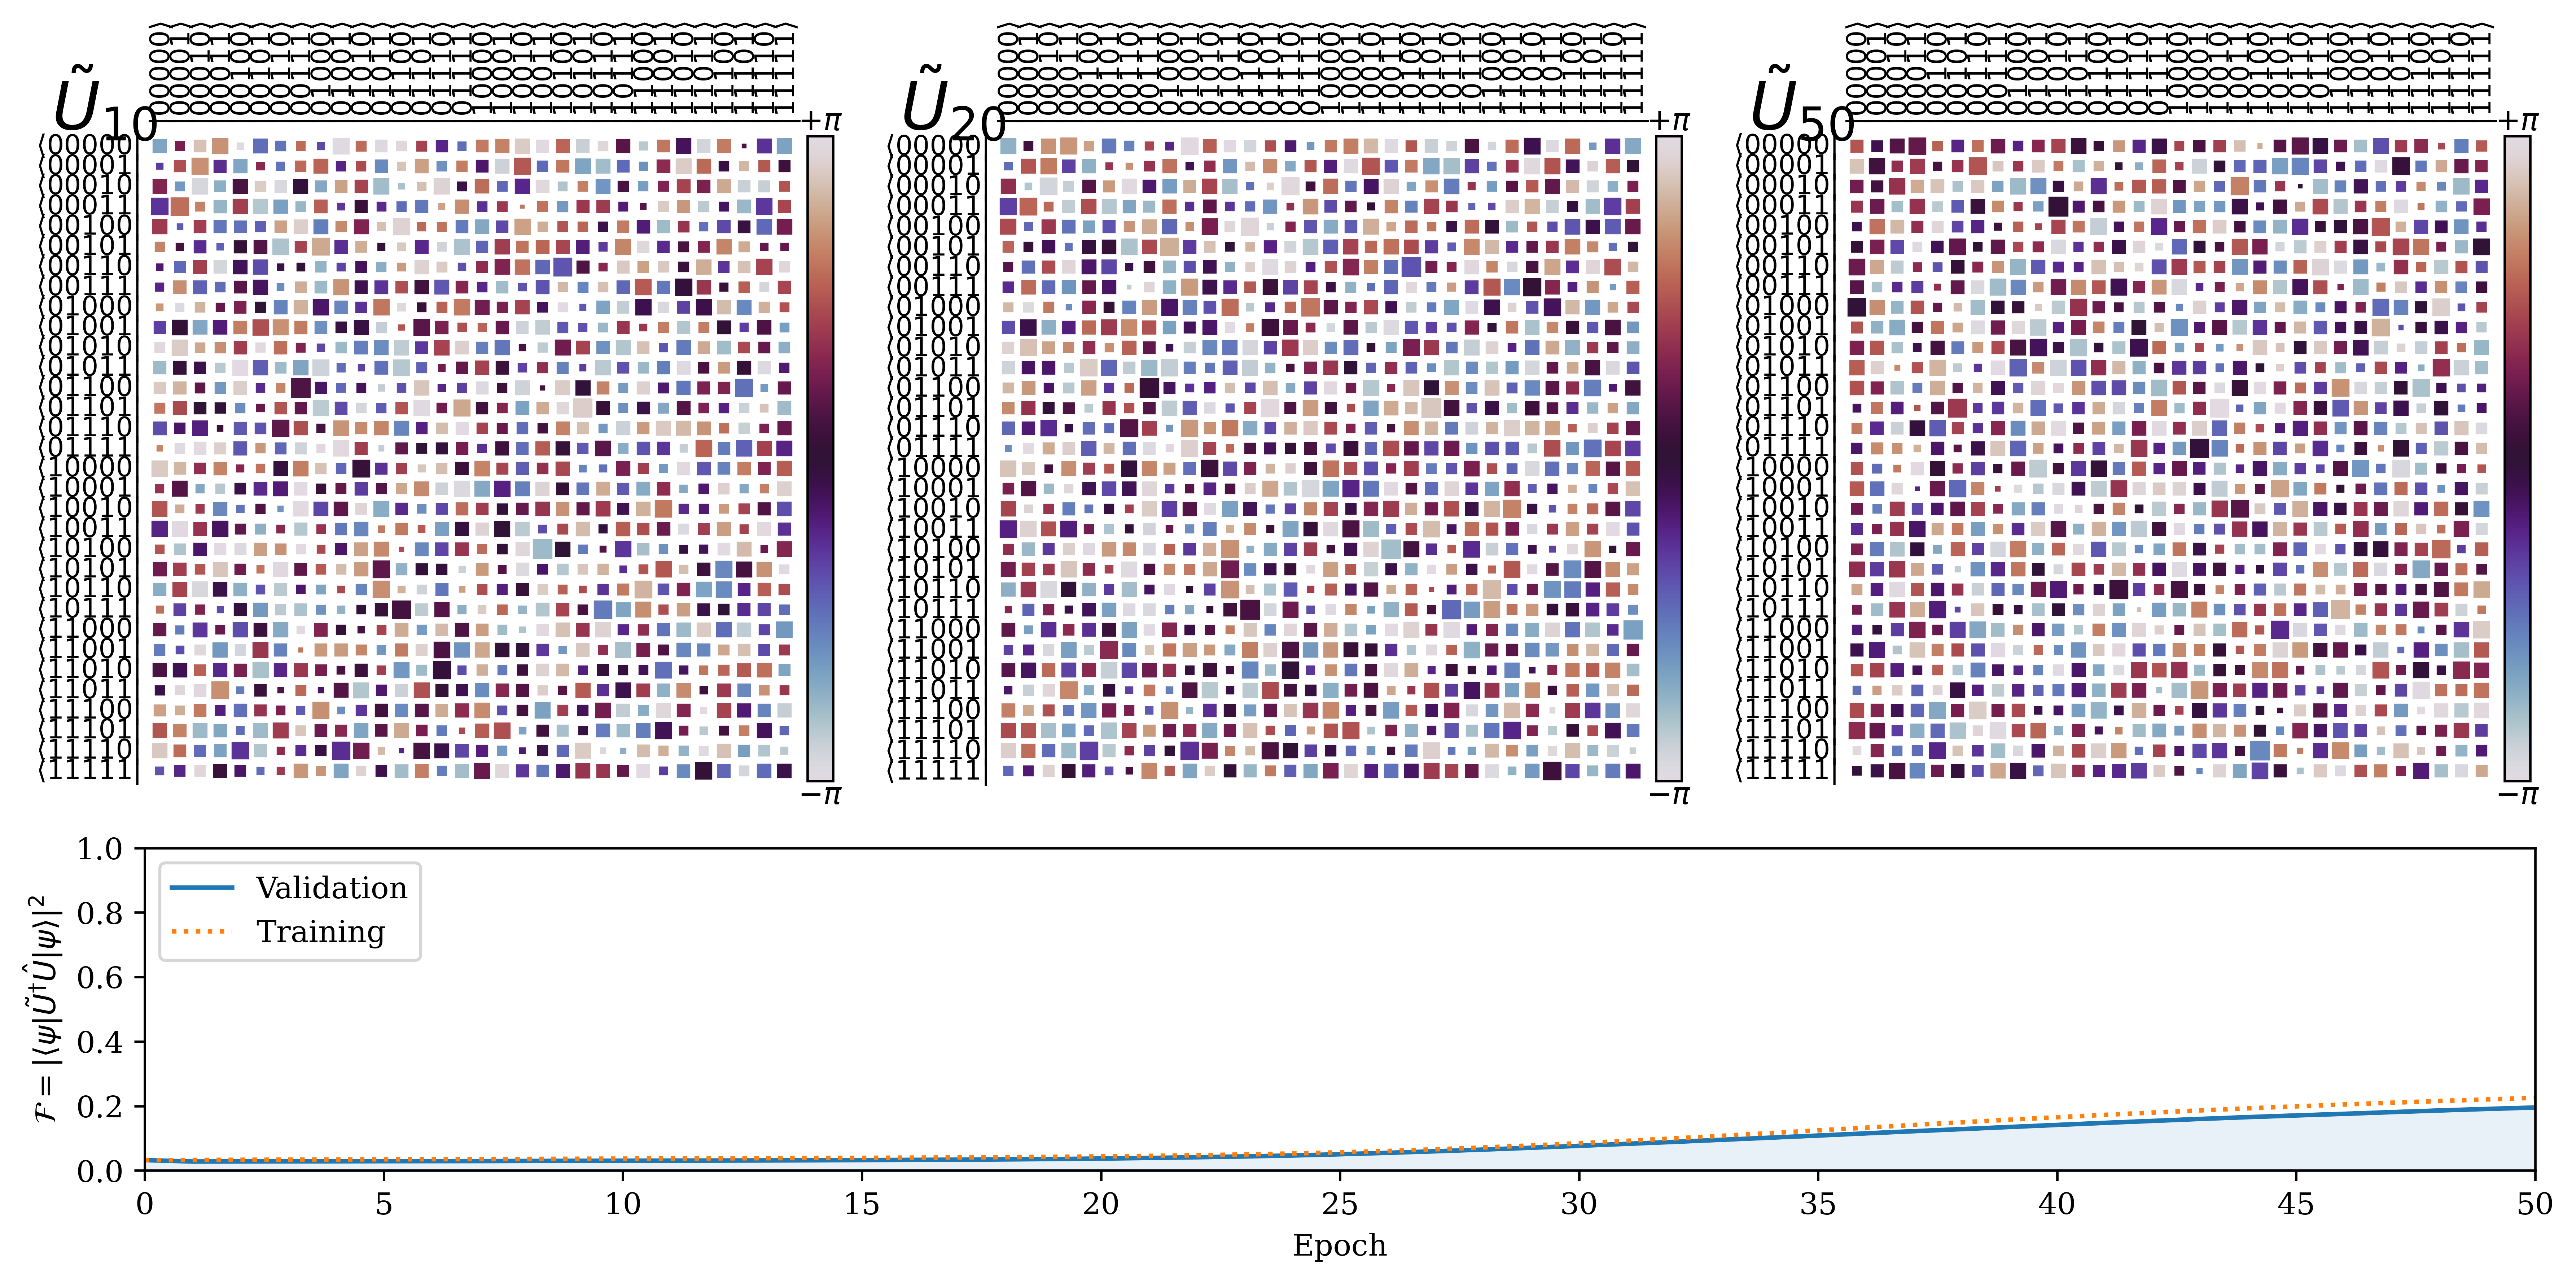

In [43]:
plt.rc('text', usetex=False)

def plot_qft_figure(filepath, t1 = 0, t2 = 25, tmax = 50, figscale = 12, savefig = False):

    f = h5py.File(filepath, 'r')

    fidelities_train = np.array(f['fidelities_train'])
    fidelities_val = np.array(f['fidelities_val'])
    operators = np.array(f['operators'])
    fidelity_init = 1 - np.array(f['fidelity_initial'])[-1]
    operator_init = np.array(f['operator_initial'])
    
    fidelities_val = np.insert(fidelities_val, 0, fidelity_init, axis=0)
    fidelities_train = np.insert(fidelities_train, 0, fidelity_init, axis=0)
    operators = np.insert(operators, 0, operator_init, axis=0)
    
    operator_targ = extract_operator_from_circuit(QFT, N)
    kets, bras = computational_basis_labels(N, include_bras=True)

    global_phase1 = np.mean(np.angle(operators[t1]/operator_targ))
    operator1 = operators[t1] / np.exp(1j * global_phase1)

    global_phase2 = np.mean(np.angle(operators[t2]/operator_targ))
    operator2 = operators[t2] / np.exp(1j * global_phase2)
    
    global_phase3 = np.mean(np.angle(operators[tmax]/operator_targ))
    operator3 = operators[tmax] / np.exp(1j * global_phase3)

    # Make figure and axis layout
    plt.rc('text', usetex=False)
    plt.rc('font', family='serif')
    fig = plt.figure(figsize=(figscale, figscale*(1/3 + 1/6)), tight_layout=True)
    gs = mpl.gridspec.GridSpec(2, 3, height_ratios = [2, 1])

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    
    # Plot antifidelity
    fidel_val = fidelities_val[0:tmax+1]
    fidel_train = fidelities_train[0:tmax+1]
    ax_bot = fig.add_subplot(gs[1, :])
    loss_plot(fidel_val, fidel_train, x_units='epochs', x_max = tmax+1, fig=fig, ax=ax_bot, log_fidelity=False)

    # Plot operator visualizations
    fidel1 = fidel_val[t1]
    hinton(operator1, xlabels=kets, ylabels=bras, fig=fig, ax=ax1, title="$\\tilde{U}_{"+str(t1)+"}$")
    
    fidel2 = fidel_val[t2]
    hinton(operator2, xlabels=kets, ylabels=bras, fig=fig, ax=ax2, title="$\\tilde{U}_{"+str(t2)+"}$")
    
    fidel_3 = fidel_val[tmax]
    hinton(operator3, xlabels=kets, ylabels=bras, fig=fig, ax=ax3, title="$\\tilde{U}_{"+str(tmax)+"}$")

    if savefig:
        plt.savefig("assets/qft_3panel.pdf", dpi=300, bbox_inches='tight', pad_inches=0)
    else:
        plt.show()
    
plot_qft_figure('operator_history_5_qubits_2022.06.06.21.07.08.h5', t1=10, t2=20, tmax=50, savefig=False)

In [19]:
fidelities

NameError: ignored

In [13]:
in_data, out_data = prepare_training_data(QFT, 2, 1000)

100%|██████████| 1000/1000 [00:00<00:00, 2402.56it/s]


In [21]:
out_data

array([[[[ 2.500e-01,  2.500e-01,  2.500e-01,  2.500e-01],
         [ 2.500e-01,  2.500e-01,  2.500e-01,  2.500e-01],
         [ 2.500e-01,  2.500e-01,  2.500e-01,  2.500e-01],
         [ 2.500e-01,  2.500e-01,  2.500e-01,  2.500e-01]],

        [[ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00],
         [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00],
         [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00],
         [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00]]],


       [[[ 2.792e-02,  1.526e-01,  3.101e-02, -2.339e-02],
         [ 1.526e-01,  9.082e-01,  1.964e-01, -1.261e-01],
         [ 3.101e-02,  1.964e-01,  4.423e-02, -2.536e-02],
         [-2.339e-02, -1.261e-01, -2.536e-02,  1.963e-02]],

        [[-5.667e-18, -4.558e-02, -1.654e-02, -1.039e-03],
         [ 4.558e-02, -2.196e-18, -3.979e-02, -4.386e-02],
         [ 1.654e-02,  3.979e-02,  5.667e-18, -1.501e-02],
         [ 1.039e-03,  4.386e-02,  1.501e-02,  2.196e-18]]],


       [[[ 6.695e-01, -6.244e-02, -4.081e-01

In [20]:
QFT()

TypeError: ignored